In [36]:
import cv2
import numpy as np
from moviepy.editor import *
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
input_video = 'motion_test.mp4'
video_cap = cv2.VideoCapture(input_video)
if not video_cap.isOpened():
    print('Unable to open: ' + input_video)

In [38]:
frame_w = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_h = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

size = (frame_w, frame_h)
size_quad = (int(2*frame_w), int(2*frame_h))

video_out_quad = cv2.VideoWriter('video_out_quad.mp4', cv2.VideoWriter_fourcc(*'XVID'), fps, size_quad)

In [39]:
def drawBannerText(frame, text, banner_height_percent = 0.08, font_scale = 0.8, text_color = (0, 255, 0), 
                   font_thickness = 2):

    banner_height = int(banner_height_percent * frame.shape[0])
    cv2.rectangle(frame, (0, 0), (frame.shape[1], banner_height), (0, 0, 0), thickness = -1)

    # Draw text on banner.
    left_offset = 20
    location = (left_offset, int(10 + (banner_height_percent * frame.shape[0]) / 2))
    cv2.putText(frame, text, location, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, 
                font_thickness, cv2.LINE_AA)

In [40]:
bg_sub = cv2.createBackgroundSubtractorKNN (history = 200)

In [41]:
ksize = (5, 5)
red = (0, 0, 255)
yellow = (0, 255, 255)

# Quad view that will be built.
#------------------------------------
# frame_fg_mask       :  frame
# frame_fg_mask_erode :  frame_erode
#------------------------------------

while True:
    ret, frame = video_cap.read()

    if frame is None:
        break
    else:
        frame_erode = frame.copy()

    # Stage 1: Motion area based on foreground mask.
    fg_mask = bg_sub.apply(frame)
    motion_area = cv2.findNonZero(fg_mask)
    x, y, w, h = cv2.boundingRect(motion_area)

    # Stage 2: Motion area based on foreground mask (with erosion)
    fg_mask_erode = cv2.erode(fg_mask, np.ones(ksize, np.uint8))
    motion_area_erode = cv2.findNonZero(fg_mask_erode)
    xe, ye, we, he = cv2.boundingRect(motion_area_erode)

    # Draw bounding box for motion area based on foreground mask
    if motion_area is not None:
        cv2.rectangle(frame, (x, y), (x + w, y + h), red, thickness = 6)

    # Draw bounding box for motion area based on foreground mask (with erosion)
    if motion_area_erode is not None:
        cv2.rectangle(frame_erode, (xe, ye), (xe + we, ye + he), red, thickness = 6)

    # Convert foreground masks to color so we can build a composite video with color annotations.
    frame_fg_mask = cv2.cvtColor(fg_mask, cv2.COLOR_GRAY2BGR)
    frame_fg_mask_erode = cv2.cvtColor(fg_mask_erode, cv2.COLOR_GRAY2BGR)

    # Annotate each video frame.
    drawBannerText(frame_fg_mask, 'Foreground Mask')
    drawBannerText(frame_fg_mask_erode, 'Foreground Mask Eroded')

    # Build quad view.
    frame_top = np.hstack([frame_fg_mask, frame])
    frame_bot = np.hstack([frame_fg_mask_erode, frame_erode])
    frame_composite = np.vstack([frame_top, frame_bot])

    # Create composite video with intermediate results (quad grid).
    fc_h, fc_w, _= frame_composite.shape
    cv2.line(frame_composite, (0, int(fc_h/2)), (fc_w, int(fc_h/2)), yellow, thickness = 1, lineType = cv2.LINE_AA)

    # Write video files.
    video_out_quad.write(frame_composite)


video_cap.release()
video_out_quad.release()

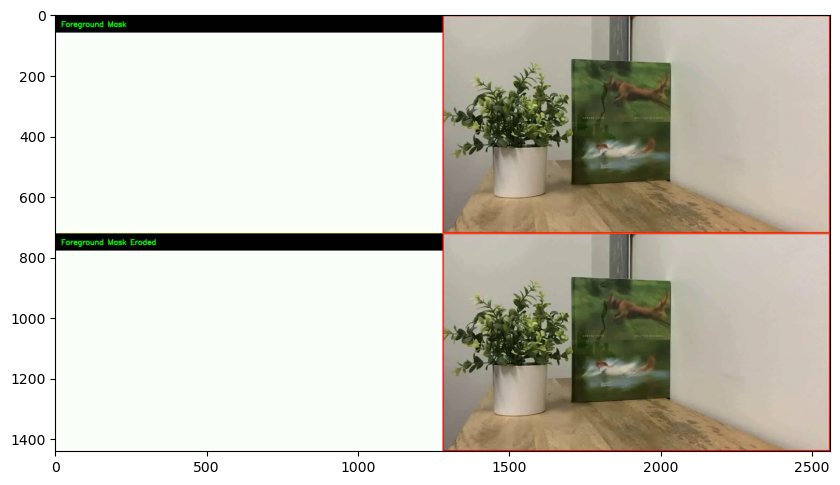

In [51]:
video_cap = cv2.VideoCapture('video_out_quad.mp4')
if not video_cap.isOpened():
    print('Unable to open: ' + input_video)
ret, frame = video_cap.read()
plt.figure(figsize = (10, 8))
plt.imshow(frame[...,::-1]) 